## 根据简单指标构建趋势，然后验证指数向趋势方向运行的概率

### 做多

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zl.csv')  # 螺纹主连日线
#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zlh.csv') # 螺纹主连小时线
#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zs.csv')  # 螺纹指数日线
#df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\zsh.csv') # 螺纹指数小时线

#构建指标
def get_DKX(df, n=10):
    df['a'] = (df.c * 3 + df.l + df.o + df.h)/6
    df['b'] = (20*df.a + 19*df.a.shift(1) + 18*df.a.shift(2) + 17*df.a.shift(3) + 
        16*df.a.shift(4) + 15*df.a.shift(5) + 14*df.a.shift(6) + 
        13*df.a.shift(7) + 12*df.a.shift(8) + 11*df.a.shift(9) + 
        10*df.a.shift(10) + 9*df.a.shift(11) + 8*df.a.shift(12) + 7*df.a.shift(13) + 
        6*df.a.shift(14) + 5*df.a.shift(15) + 4*df.a.shift(16) + 
        3*df.a.shift(17) + 2*df.a.shift(18) + 1*df.a.shift(19))/210
    df['d'] = df.b.rolling(n).mean()
    return df.drop(['a'], axis=1)
def get_nhh(df, n):
    '''前n天最高价最高点（不包含当天）'''
    df['nhh'] = df.h.shift(1).rolling(window=n, center=False).max()
    return df

def get_nll(df, n):
    '''前n天最低点（不包含当天）'''
    df['nll'] = df.l.shift(1).rolling(window=n, center=False).min()
    return df


# 显示结果的函数
def result(df):
    '''df is dataframe'''
    df['c_up'] = np.where( df.c > df.c.shift(1), 1, 0 )
    gailvc = np.round(df.c_up.sum()/df.shape[0], 3) * 100
    gailvc = str(gailvc)[:4]
    #print( '收盘价比前一天收盘价高的概率 {}% '.format(gailv)) # 某条件下   c比前一天高的概率
    
    df['l_up'] = np.where( df.l > df.l.shift(1), 1, 0 ) # 比前一天最低点高
    #df['l_up'] = np.where( df.l > df.nll, 1, 0 ) # 这样就是最低点比前两天最低点高
    gailvl = round(df.l_up.sum()/df.shape[0], 3) * 100
    gailvl = str(gailvl)[:4]
    #print('最低价比前一天最低价高的概率 {}%'.format(gailv2)) # 某条件下   low比前一天高的概率
    
    df['o_up'] = np.where( df.o > df.o.shift(1), 1, 0 )
    gailvo = round(df.o_up.sum()/df.shape[0], 3) * 100
    gailvo = str(gailvo)[:4]
    
    
    df['h_up'] = np.where( df.h > df.h.shift(1), 1, 0 )
    gailvh = round(df.h_up.sum()/df.shape[0], 3) * 100
    gailvh = str(gailvh)[:4]
    return gailvo, gailvc, gailvh, gailvl

def ready(whichdata):
    df = pd.read_csv(r'E:\workspace\qqqhhh\data\rb\{}.csv'.format(whichdata))
    df = get_DKX(df) 
    df = get_nhh(df, 2)
    df = get_nll(df, 2)
    df['ma'] = df.c.rolling(window=20, center=False).mean()
    return df.copy()

columns = ['主连日线','主连小时线','指数日线','指数小时线']
# 前4个同向的概率，后4个反向
index = ['DKXb向上','K线高于DKXb','ma向上','K线高于ma','DKXb向下','K线低于DKXb','ma向下','K线低于ma']
# 收盘价各种情况比较
dfc = pd.DataFrame(index=index, columns=columns)
# 最低价各种情况比较
dfl = pd.DataFrame(index=index, columns=columns)
# 收盘价各种情况比较
dfo = pd.DataFrame(index=index, columns=columns)
# 最低价各种情况比较
dfh = pd.DataFrame(index=index, columns=columns)



In [6]:
# 条件筛选，后的数据
def process(data, column, result_func=result):
    # 过滤出DKX 的b线 向上的数据
    df = ready(data)
    df['contidion'] = np.where( df.b > df.b.shift(1), 1, 0)
    #df['contidion'] = np.where( (df.b > df.b.shift(1)) & (df.h < df.nhh), 1, 0)
    df = df.loc[df.contidion==1,:]
    o1, c1, h1, l1 = result_func(df)
    
    # 过滤出DKX 的b线 向下的数据
    df = ready(data)
    df['contidion'] = np.where(df.b < df.b.shift(1), 1, 0)
    #df['contidion'] = np.where( (df.b < df.b.shift(1)) & ((df.l > df.nll)), 1, 0)
    df = df.loc[df.contidion==1,:]
    o1b, c1b, h1b, l1b = result_func(df)
    
    # 过滤出close比DKX b线 高的数据
    df = ready(data)
    df['contidion'] = np.where(df.c > df.b, 1, 0)
    df = df.loc[df.contidion==1,:]
    o2, c2, h2, l2 = result_func(df)
    
    # 过滤出close比DKX b线 低的数据
    df = ready(data)
    df['contidion'] = np.where(df.c < df.b, 1, 0)
    df = df.loc[df.contidion==1,:]
    o2b, c2b, h2b, l2b = result_func(df)
    
    # 过滤出ma向上的数据
    df = ready(data)
    df['contidion'] = np.where(df.ma > df.ma.shift(1), 1, 0)
    df = df.loc[df.contidion==1, :]
    o3, c3, h3, l3 = result_func(df)
    
    # 过滤出ma向下的数据
    df = ready(data)
    df['contidion'] = np.where(df.ma < df.ma.shift(1), 1, 0)
    df = df.loc[df.contidion==1, :]
    o3b, c3b, h3b, l3b = result_func(df)
    
    # close在ma上的数据
    df = ready(data)
    df['contidion'] = np.where(df.c > df.ma, 1, 0)
    df = df.loc[df.contidion==1, :]
    o4, c4, h4, l4 = result_func(df)
    
    # close在ma下的数据
    df = ready(data)
    df['contidion'] = np.where(df.c < df.ma, 1, 0)
    df = df.loc[df.contidion==1, :]
    o4b, c4b, h4b, l4b  = result_func(df)
    
    dfo[column] = [o1,o2,o3,o4,o1b,o2b,o3b,o4b]
    dfc[column] = [c1,c2,c3,c4,c1b,c2b,c3b,c4b]
    dfh[column] = [h1,h2,h3,h4,h1b,h2b,h3b,h4b]
    dfl[column] = [l1,l2,l3,l4,l1b,l2b,l3b,l4b]
    #print(dfc)
    
process('zl', '主连日线')
process('zlh', '主连小时线')
process('zs', '指数日线')
process('zsh', '指数小时线')

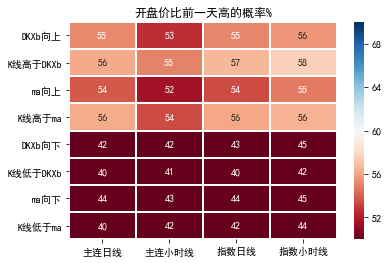

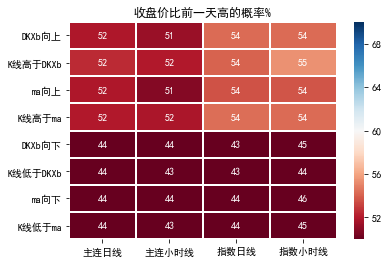

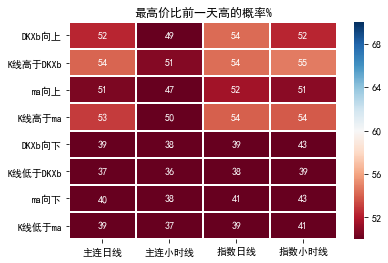

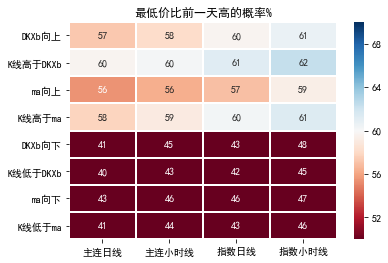

In [7]:
def plot_heatmap(data, title):
    plt.rcParams['font.sans-serif'] = ['SimHei'] 
    plt.title(title)
    data = data.astype(float)
    ax = sns.heatmap(data, center=60, linewidths=1, 
                     cmap="RdBu", vmin=50, vmax=70, annot=True)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=0)
    ax.set_yticklabels(ax.yaxis.get_majorticklabels(), rotation=0)
    plt.show()
    
plot_heatmap(dfo, '开盘价比前一天高的概率%')
plot_heatmap(dfc, '收盘价比前一天高的概率%')
plot_heatmap(dfh, '最高价比前一天高的概率%')
plot_heatmap(dfl, '最低价比前一天高的概率%')

### 做空

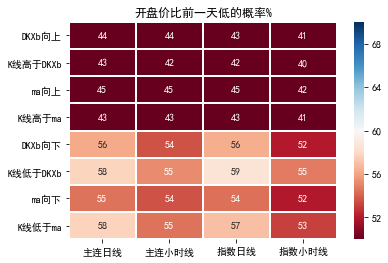

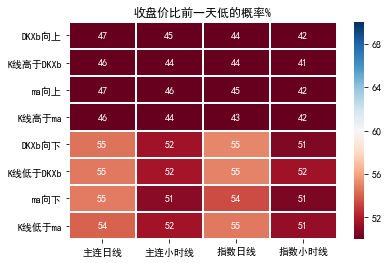

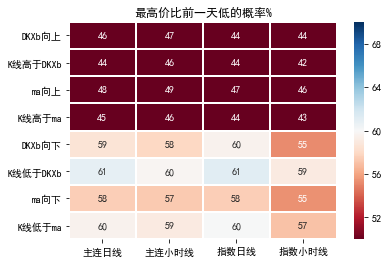

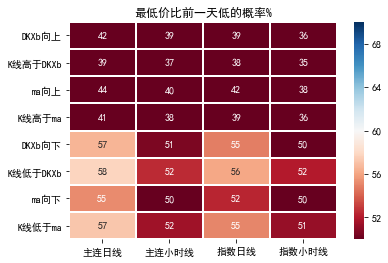

In [8]:
# 显示结果的函数  做空
def result_sell(df):
    '''df is dataframe'''
    df['c_down'] = np.where( df.c < df.c.shift(1), 1, 0 )
    gailvc = np.round(df.c_down.sum()/df.shape[0], 3) * 100
    gailvc = str(gailvc)[:4]
    
    df['l_down'] = np.where( df.l < df.l.shift(1), 1, 0 )
    gailvl = round(df.l_down.sum()/df.shape[0], 3) * 100
    gailvl = str(gailvl)[:4]
    
    df['o_down'] = np.where( df.o < df.o.shift(1), 1, 0 )
    gailvo = round(df.o_down.sum()/df.shape[0], 3) * 100
    gailvo = str(gailvo)[:4]
    
    df['h_down'] = np.where( df.h < df.h.shift(1), 1, 0 )
    #df['h_down'] = np.where( df.h < df.nhh, 1, 0 )  # 比前两天高点低
    gailvh = round(df.h_down.sum()/df.shape[0], 3) * 100
    gailvh = str(gailvh)[:4]
    return gailvo, gailvc, gailvh, gailvl

# 收盘价各种情况比较
dfc = pd.DataFrame(index=index, columns=columns)
# 最低价各种情况比较
dfl = pd.DataFrame(index=index, columns=columns)
# 收盘价各种情况比较
dfo = pd.DataFrame(index=index, columns=columns)
# 最低价各种情况比较
dfh = pd.DataFrame(index=index, columns=columns)

process('zl', '主连日线', result_func=result_sell)
process('zlh', '主连小时线', result_func=result_sell)
process('zs', '指数日线', result_func=result_sell)
process('zsh', '指数小时线', result_func=result_sell)

plot_heatmap(dfo, '开盘价比前一天低的概率%')
plot_heatmap(dfc, '收盘价比前一天低的概率%')
plot_heatmap(dfh, '最高价比前一天低的概率%')
plot_heatmap(dfl, '最低价比前一天低的概率%')

### 结论：在我定义的向上的趋势中，低点向上的趋势最明显，同样，在向下的趋势中，高点向下的趋势最明显； 而收盘价的趋势最不明显

## 既然得出了以上的结论，接着看
## 1,向上的趋势中，低点比前两天低点高的概率
## 2,向下的趋势中，高点比前两天高点低的概率
## 